## Imports

In [1]:
import sys
import numpy as np
import pandas as pd
from os.path import abspath, join as opj
from tqdm.notebook import tqdm

sys.path.insert(0, abspath('../helpers/'))
from participant import Participant
from experiment import Experiment

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Set paths and params

In [2]:
raw_path = '../../data/raw/psiturk-data-raw.tsv'
figdir = '../../paper/figs/'
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('hls')
plt.rcParams['pdf.fonttype'] = 42
cp, c3, c2, c1 = sns.color_palette()[:4]

## Define plotting function

In [3]:
def bootstrap_ci(
    M, 
    ci=95, 
    n_boots=1000, 
    color='#1f77b4', 
    alpha=0.3, 
    return_bounds=False, 
    label=None, 
    ax=None
):
    x_data = np.arange(M.shape[0])
    y = M.mean(axis=1)
    ci_low = (100 - ci) / 2
    ci_high = 100 - ci_low
    L, U = np.empty(x_data.shape), np.empty(x_data.shape)
  # constructs a single resample
    boot_mean = lambda x: np.random.choice(x, size=len(x), replace=True).mean()
    for x_val in x_data:
        x_dists = M[x_val]
        boot_iter = (boot_mean(x_dists) for n in range(n_boots))
        boots = np.fromiter(boot_iter, dtype=float)
        # use percentile bootstrap (seaborn default method)
        L[x_val] = np.percentile(boots, ci_low)
        U[x_val] = np.percentile(boots, ci_high)
    if ax is not None:
        # error ribbons
        ax.fill_between(x_data, L, U, color=color, alpha=alpha)
        # opaque line
        ax.plot(x_data, y, color=color, label=label)
        returns = []
    else:
        h1 = plt.fill_between(x_data, L, U, color=color, alpha=alpha)
        h2 = plt.plot(x_data, y, color=color, label=label)
        returns = [h1, h2]
    if return_bounds:
        returns.extend([L, U])
    return returns

## Load data

In [4]:
exp = Experiment()
exp.load_lecture_trajs()
exp.load_question_vectors()
raw_data = pd.read_csv(raw_path, sep='\t', index_col='Unnamed: 0')
raw_data.head()

,uniqueid,assignmentid,workerid,hitid,ipaddress,browser,platform,language,cond,counterbalance,codeversion,beginhit,beginexp,endhit,bonus,status,mode,datastring
0,debuga32joxa6zu7q0y:debug3aqf3rz55aocyv9v9oc6r...,3AQF3RZ55AOCYV9V9OC6RCXJB5FF69,A32JOXA6ZU7Q0Y,33K3E8REWX1EFBLACVAPTDY1FXBX8T,172.20.0.5,safari,macos,UNKNOWN,0,0,1.0,2019-04-26 17:47:30,NaN,NaN,0,1,sandbox,"{'condition': 0, 'counterbalance': 0, 'assignm..."
1,debuga32joxa6zu7q0y:debug304sm51wa5ar8cvcbztd9...,304SM51WA5AR8CVCBZTD9R2QEXQSBY,A32JOXA6ZU7Q0Y,391FPZIE4DSFRIS8AUT8MJSWOZUHUC,172.20.0.5,safari,macos,UNKNOWN,0,0,1.0,2019-04-29 18:43:33,NaN,NaN,0,1,sandbox,"{'condition': 0, 'counterbalance': 0, 'assignm..."
2,debuga32joxa6zu7q0y:debug3aqf3rz55aocyv9v9oc6r...,3AQF3RZ55AOCYV9V9OC6RCXJB6M6F9,A32JOXA6ZU7Q0Y,31MBOZ6PAPXLRKUYFON6K5ZXYGXCL5,172.20.0.5,safari,macos,UNKNOWN,0,0,1.0,2019-04-29 19:29:40,NaN,NaN,0,1,sandbox,"{'condition': 0, 'counterbalance': 0, 'assignm..."
3,debugdebugwzop7d:debugdebug4j19zm,3OE22WJIGKUURVP5JML3JHFDLUOUQ4,A32JOXA6ZU7Q0Y,3P520RYKCIC3BP8D9SSZXMP6JRR5U9,172.20.0.5,safari,macos,UNKNOWN,0,0,1.0,2019-05-01 19:34:15,NaN,NaN,0,1,sandbox,"{'condition': 0, 'counterbalance': 0, 'assignm..."
4,debuga32joxa6zu7q0y:debug3dzqrbdbsnlm5hrzw6e7r...,3DZQRBDBSNLM5HRZW6E7R84EQ50S3U,A32JOXA6ZU7Q0Y,36FFXPMSTAUKED8BE8HZND076EHHOC,172.20.0.5,safari,macos,UNKNOWN,0,0,1.0,2019-05-03 17:54:55,NaN,NaN,0,1,sandbox,"{'condition': 0, 'counterbalance': 0, 'assignm..."


## Create Participant objects

In [5]:
participants = []
for ix, row in tqdm(raw_data.iterrows(), total=raw_data.shape[0], leave=False):
    p = Participant.from_psiturk(row, subid=f'P{ix + 1}')
    participants.append(p)

In [6]:
participants[0].head()

P1


,qID,accuracy,response,qset,lecture
0,13,1,A,0,1
1,21,0,B,0,2
2,12,0,D,0,1
3,16,1,A,0,2
4,28,1,A,0,2


## Reconstruct memory traces for each set of quiz questions, for each lecture

In [7]:
# Participant object to store across-participant avgerages
avg_participant = Participant('avg')

traces = {}
for lecture in ['forces', 'bos']:
    lecture_traj = exp.get_lecture_traj(lecture)
    trace_arr = np.empty((3, 50, lecture_traj.shape[0]), dtype=np.float64)
    for qset in range(3):
        store_key = f'{lecture}_qset{qset}'
        # reconstruct trace for each lecture, for each question set
        for i, p in enumerate(tqdm(participants, desc=f'{lecture}, {qset+1}/3', 
                                   leave=False)):
            # store trace in participant data object
            trace_arr[qset, i] = p.reconstruct_trace(exp, lecture=lecture, 
                                                     qset=qset, store=store_key)
        # store average in avg participant object
        avg_participant.store_trace(trace_arr[qset].mean(axis=0), store_key)
    traces[lecture] = trace_arr

## Save Participant objects with reconstructed traces

In [8]:
for p in participants:
    p.save(allow_overwrite=True)
avg_participant.save(allow_overwrite=True)

## Plot model-derived content mastery

In [9]:
ff_traces = np.swapaxes(traces['forces'], 1, 2)
bos_traces = np.swapaxes(traces['bos'], 1, 2)

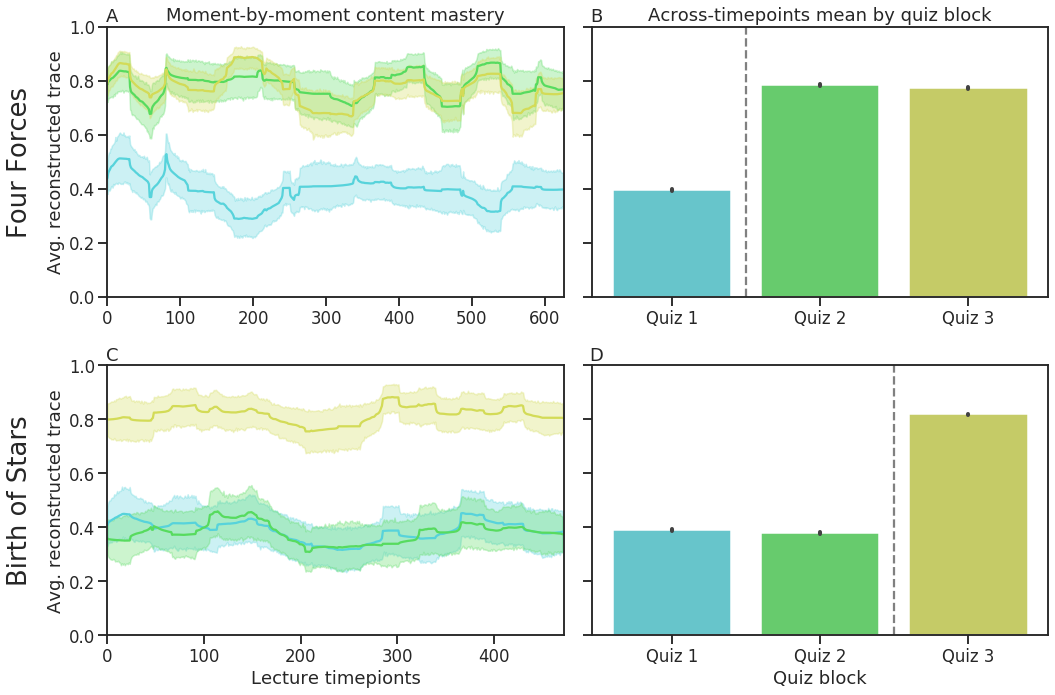

In [10]:
fig, axarr = plt.subplots(2, 2, sharey=True)
fig.set_size_inches(15, 10)
((a, b),
 (c, d)) = axarr

bootstrap_ci(ff_traces[0], color=c1, ax=a)
bootstrap_ci(ff_traces[1], color=c2, ax=a)
bootstrap_ci(ff_traces[2], color=c3, ax=a)
a.set_ylim(0, 1)
a.set_xlim(0, ff_traces[0].shape[0])
a.set_ylabel('Avg. reconstructed trace')
a.set_title('Moment-by-moment content mastery')
a.annotate('Four Forces', xy=(-.75, .5), xycoords=a.yaxis.label, 
           size='x-large', rotation=90, ha='right', va='center')

sns.barplot(data=np.split(ff_traces, 3), palette=[c1, c2, c3], ax=b)
b.set_xticklabels(['Quiz 1', 'Quiz 2', 'Quiz 3'])
b.vlines(x=.5, ymin=0, ymax=1, linestyles='dashed', colors='gray')
b.set_ylim(0, 1)
b.set_title('Across-timepoints mean by quiz block')

bootstrap_ci(bos_traces[0], color=c1, ax=c)
bootstrap_ci(bos_traces[1], color=c2, ax=c)
bootstrap_ci(bos_traces[2], color=c3, ax=c)
c.set_ylim(0, 1)
c.set_xlim(0, bos_traces[0].shape[0])
c.set_xlabel('Lecture timepionts')
c.set_ylabel('Avg. reconstructed trace')
c.annotate('Birth of Stars', xy=(-.75, .5), xycoords=c.yaxis.label, 
           size='x-large', rotation=90, ha='right', va='center')

sns.barplot(data=np.split(bos_traces, 3), palette=[c1, c2, c3], ax=d)
d.set_xticklabels(['Quiz 1', 'Quiz 2', 'Quiz 3'])
d.vlines(x=1.5, ymin=0, ymax=1, linestyles='dashed', colors='gray')
d.set_ylim(0, 1)
d.set_xlabel('Quiz block')

labels = 'ABCD'
for i, ax in enumerate((a, b, c, d)):
    ax.text(0.01, 1.02, labels[i], horizontalalignment='center', 
            transform=ax.transAxes, fontsize=18)

plt.tight_layout()
# plt.savefig(opj(figdir, 'content-mastery.pdf'), bbox_inches='tight')
plt.show()